In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
properties = [
    Atomic(T_A < RIF(35)),
]

## Self-Adaptation Loop Integration

In [11]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         uncertainty_calibrator=None,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running verified monitoring for anomaly between times 1002.5938409201124 and 1035.5938409201124
ran verified simulation in 14.202608346939087 sec
running verified monitoring for anomaly between times 1068.5938409201124 and 1101.5938409201124
ran verified simulation in 17.385908126831055 sec
running verified monitoring for anomaly between times 2013.5938409201124 and 2046.5938409201124
ran verified simulation in 16.14744734764099 sec
running verified monitoring for anomaly between times 2076.593840920112 and 2109.593840920112
ran verified simulation in 16.743468046188354 sec


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

In [12]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(1002.5938409201124, 1035.5938409201124),
 (1068.5938409201124, 1101.5938409201124),
 (2013.5938409201124, 2046.5938409201124),
 (2076.593840920112, 2109.593840920112)]

In [13]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(1038.5938409201124,
  1538.5938409201124,
  118.89228178690599?,
  81.238146323910371?,
  21,
  3.0,
  10,
  5,
  146.80090801038583,
  7.940068517942851,
  227.76228512,
  1.92343277),
 (1104.5938409201124,
  1604.5938409201124,
  103.27713248422768?,
  38.485579315455411?,
  21,
  3.0,
  10,
  5,
  136.85583104560897,
  7.893908555093671,
  227.76228512,
  1.92343277),
 (2049.5938409201126,
  2549.5938409201126,
  60.588879932682709?,
  33.482535534818226?,
  21,
  3.0,
  10,
  0,
  147.42537325341118,
  0.7459200537907551,
  227.76228512,
  1.92343277),
 (2112.593840920112,
  2612.593840920112,
  60.523504787607678?,
  45.201485821124387?,
  21,
  3.0,
  10,
  1,
  145.67721692874488,
  0.7915667470569048,
  227.76228512,
  1.92343277)]

In [14]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[Signal([1038.5938409201123 .. 1538.5938409201124], [([1038.5938409201123 .. 1097.9791640004587], False), ([1097.9791789427381 .. 1538.5938409201124], True)], mask=None)],
 [Signal([1104.5938409201123 .. 1604.5938409201124], [([1104.5938409201123 .. 1135.0272313704268], False), ([1135.0272377656967 .. 1604.5938409201124], True)], mask=None)],
 [Signal([2049.5938409201125 .. 2549.5938409201126], [([2049.5938409201125 .. 2224.9568888097233], False), ([2224.9568888102467 .. 2549.5938409201126], True)], mask=None)],
 [Signal([2112.5938409201121 .. 2612.5938409201122], [([2112.5938409201121 .. 2612.5938409201122], False)], mask=None)]]

### Manually apply uncertainty calibration for 3rd Anomaly

In [15]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(1104.5938409201124,
 1604.5938409201124,
 103.27713248422768?,
 38.485579315455411?,
 21,
 3.0,
 10,
 5,
 136.85583104560897,
 7.893908555093671,
 227.76228512,
 1.92343277)

In [16]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[1])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[1]

ran verified simulation in 17.517802715301514 sec


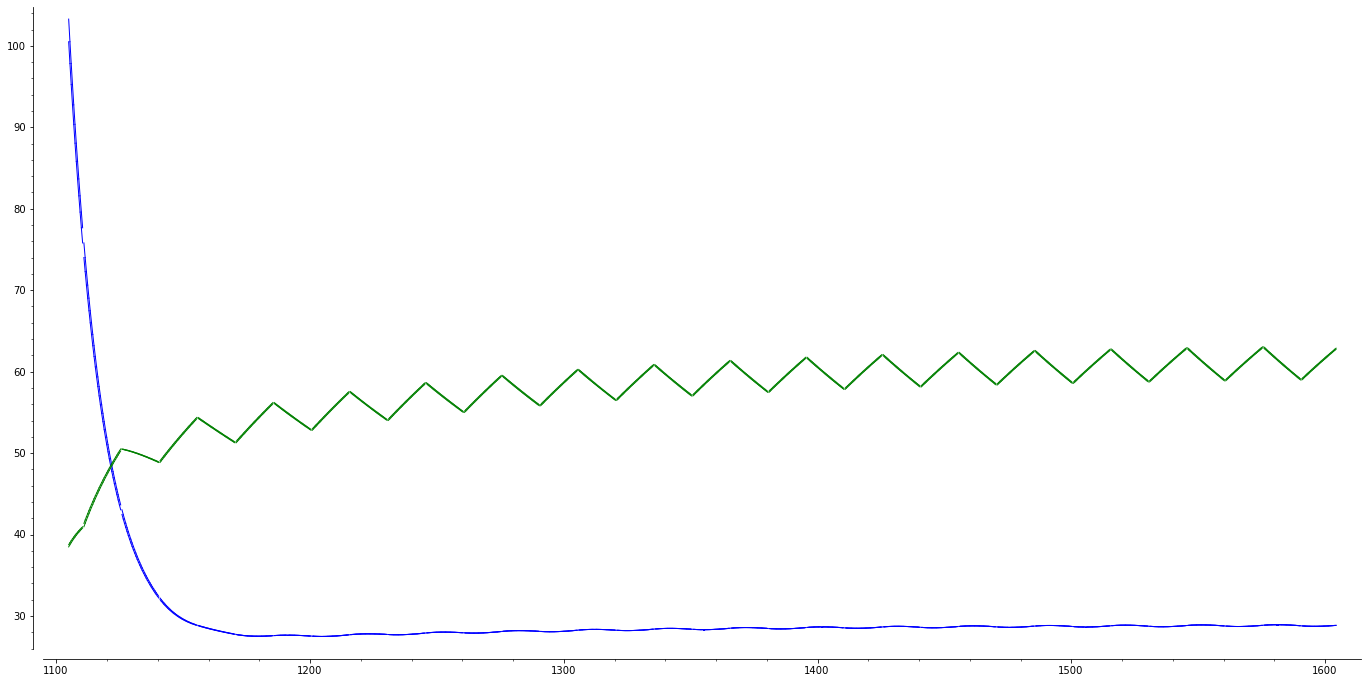

In [17]:
p = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p.matplotlib()

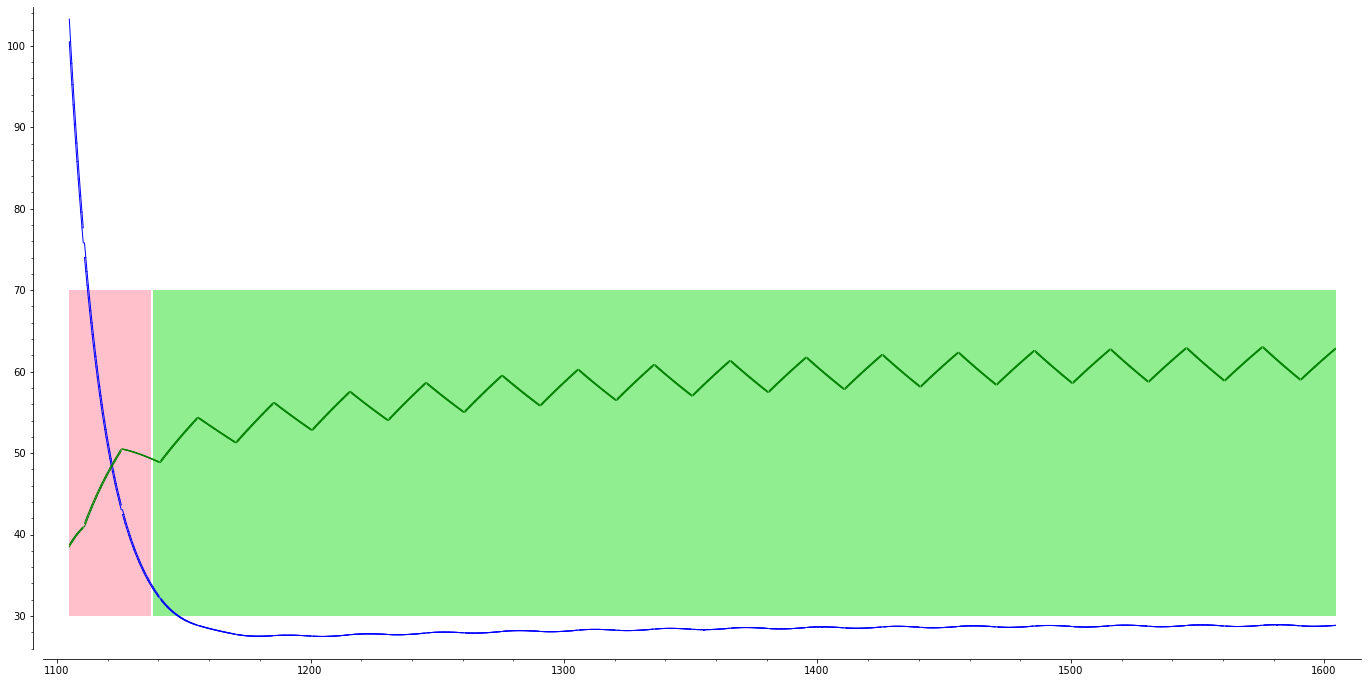

In [18]:
p1 = (verified_sigs3[0].plot(y_range=(30, 70)) + p)
p1.set_aspect_ratio('auto')
p1.matplotlib()

In [19]:
tstart, tend = m.self_adaptation_manager.state_machine.anomaly_durations[1]

In [20]:
 success, C_air, G_box, C_heater, G_heater = calibrator.calibrate(tstart, tend)

In [21]:
m.self_adaptation_manager.state_machine.kalman_filter.update_parameters(C_air, G_box, C_heater, G_heater)

In [22]:
C_air, G_box, C_heater, G_heater

(137.290907077744, 7.897122578958927, 227.76228512, 1.92343277)

In [23]:
signals, t_start_idx, t_end_idx = calibrator.database.get_plant_signals_between(tstart, tend)
times = signals["time"][t_start_idx:t_end_idx]
reference_T = signals["T"][t_start_idx:t_end_idx]
ctrl_signal = signals["in_heater_on"][t_start_idx+1:t_end_idx+1]
reference_T_heater = signals["T_heater"][t_start_idx:t_end_idx]
room_T = signals["in_room_temperature"][t_start_idx:t_end_idx]

In [24]:
sol, model = calibrator.plant_simulator.run_simulation(
    times, reference_T[0], reference_T_heater[0], room_T, ctrl_signal,
    C_air, G_box, C_heater, G_heater)

In [25]:
from digital_twin.calibration.uncertainty_calibrator import *

In [26]:
system = UncertaintyCalibrationSystem(times,
    reference_T[0], reference_T_heater[0],
    C_air, G_box, C_heater, G_heater,
    room_T, ctrl_signal)

In [27]:
prob = UncertaintyCalibrationProblem(
    (times, reference_T, reference_T_heater),
    system,
)

In [28]:
from verified_twin.traces import NumericalContinuousTrace

In [29]:
reference_T_heater

[103.27713248422768,
 101.65268048711668,
 100.0616169505955,
 99.98739590833614,
 100.05573378987371,
 100.11746187901788,
 100.17369949721378,
 100.22535809878524,
 98.78879398819213,
 97.2380340912575,
 95.7219380960609]

In [30]:
ctrl_signal

[False, False, True, True, True, True, True, False, False, False, False]

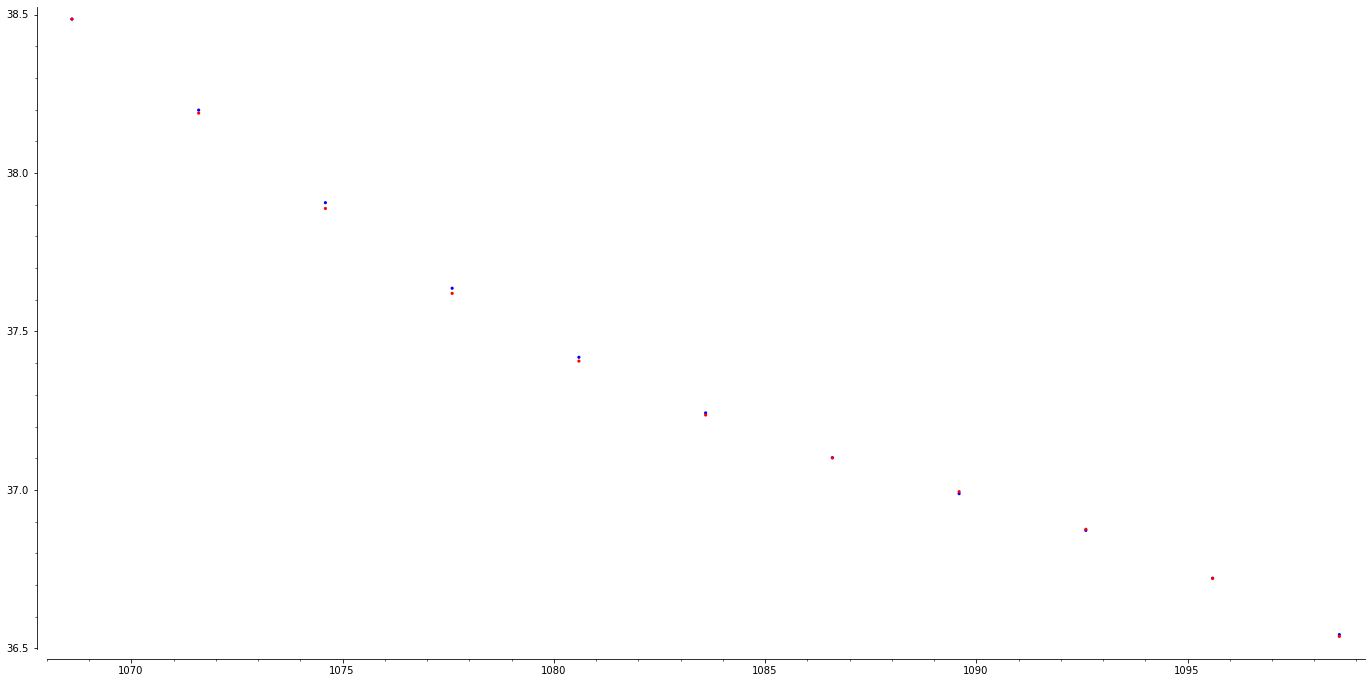

In [31]:
pT = ( sg.points(zip(times, reference_T), color='blue')
     + sg.points(zip(times, sol.y[1]), color='red') )
pT.matplotlib()

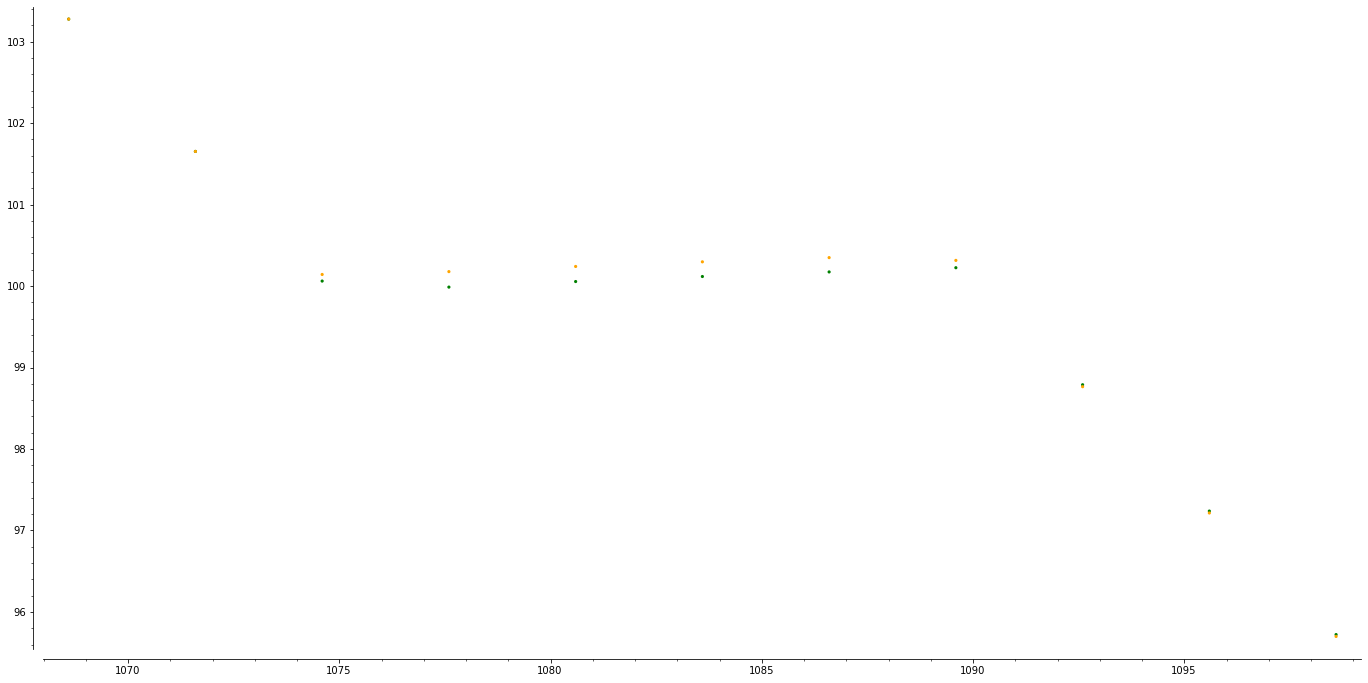

In [32]:
pT_H = ( sg.points(zip(times, reference_T_heater), color='green')
       + sg.points(zip(times, sol.y[2]), color='orange') )
pT_H.matplotlib()

In [33]:
verified_trace3b, verified_model3b = VerifiedPlantMonitor4Params.run_simulation(tstart, tend, *m.self_adaptation_manager.state_machine.anomaly_parameters[1][2:])

ran verified simulation in 0.8186683654785156 sec


In [34]:
from verified_twin.incubator_models import *


In [35]:
verified_trace3c = system.verified_trace(2**-2, 2**-2, 2**-2, 2**-2)

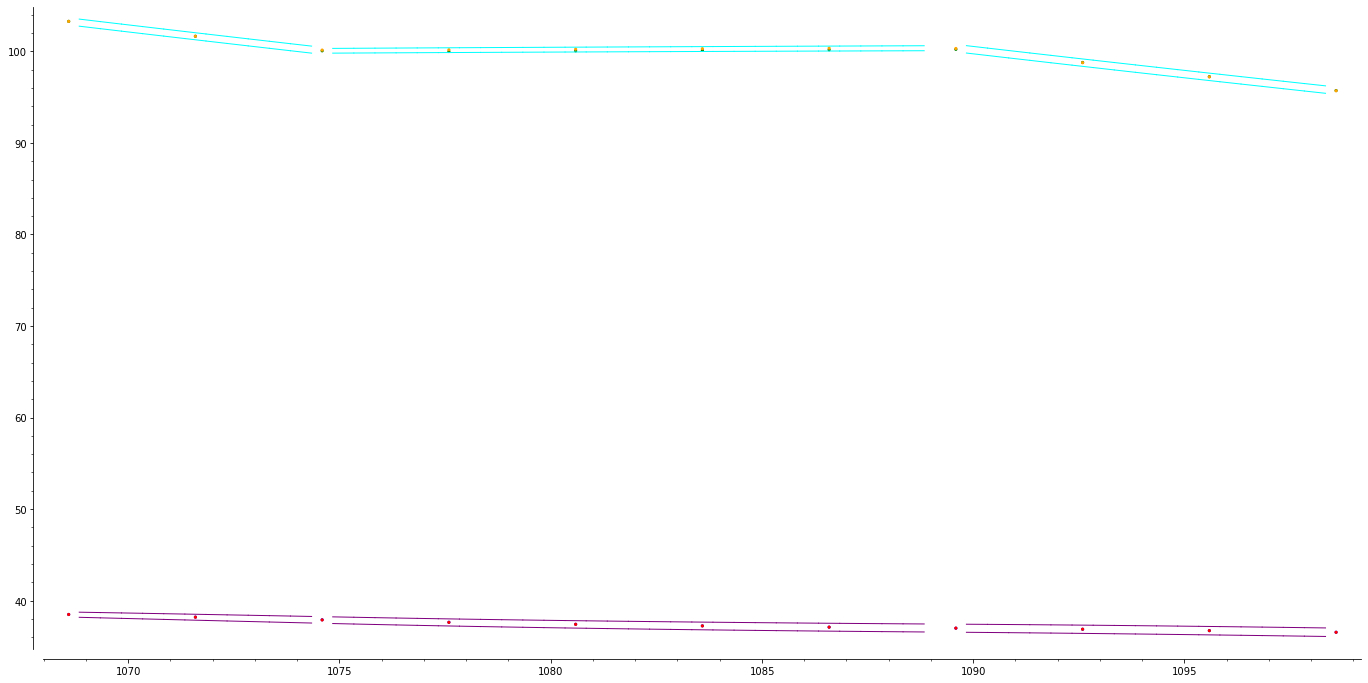

In [36]:
(  pT + pT_H
 + verified_trace3c.plot(('T_A', 'T_H'), color=('purple', 'cyan'))
).matplotlib()

In [37]:
verified_trace3d = system.verified_trace(-2**1, -2**1, 2**-1, 2**-1)

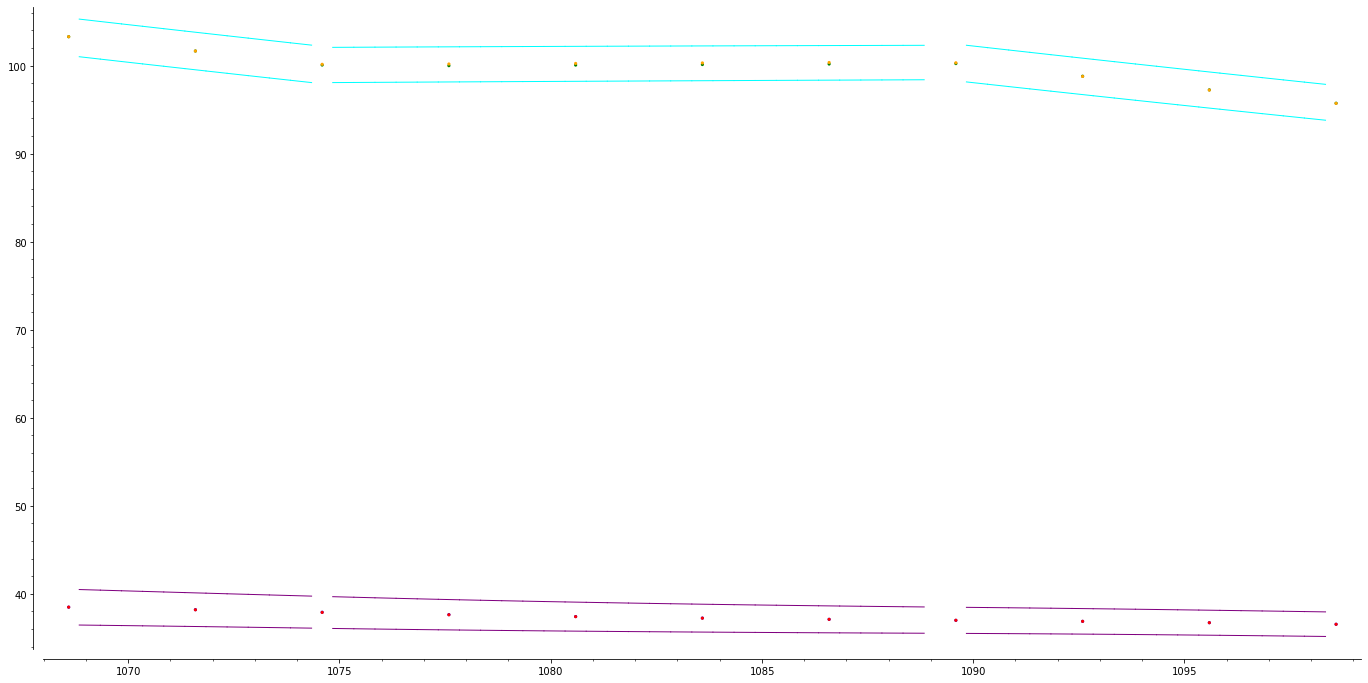

In [38]:
(  pT + pT_H
 + verified_trace3d.plot(('T_A', 'T_H'), color=('purple', 'cyan'))
).matplotlib()

In [39]:
from scipy.optimize import minimize

sol = minimize(
    prob.cost,
    np.array([2,2,0.5,0.5]),
    method='Nelder-Mead',
    bounds=[(0, 4), (0, 4), (0, 4), (0, 4)],
    options={'maxiter': 10, 'xatol': 1, 'fatol': 0.1},
)

In [40]:
sol.success

False

In [41]:
sol.x

array([0.58681641, 2.42608643, 0.55488586, 0.52357483])

In [42]:
verified_trace3e = system.verified_trace(*sol.x)

In [43]:
from digital_twin.calibration.uncertainty_calibrator import violation_degree

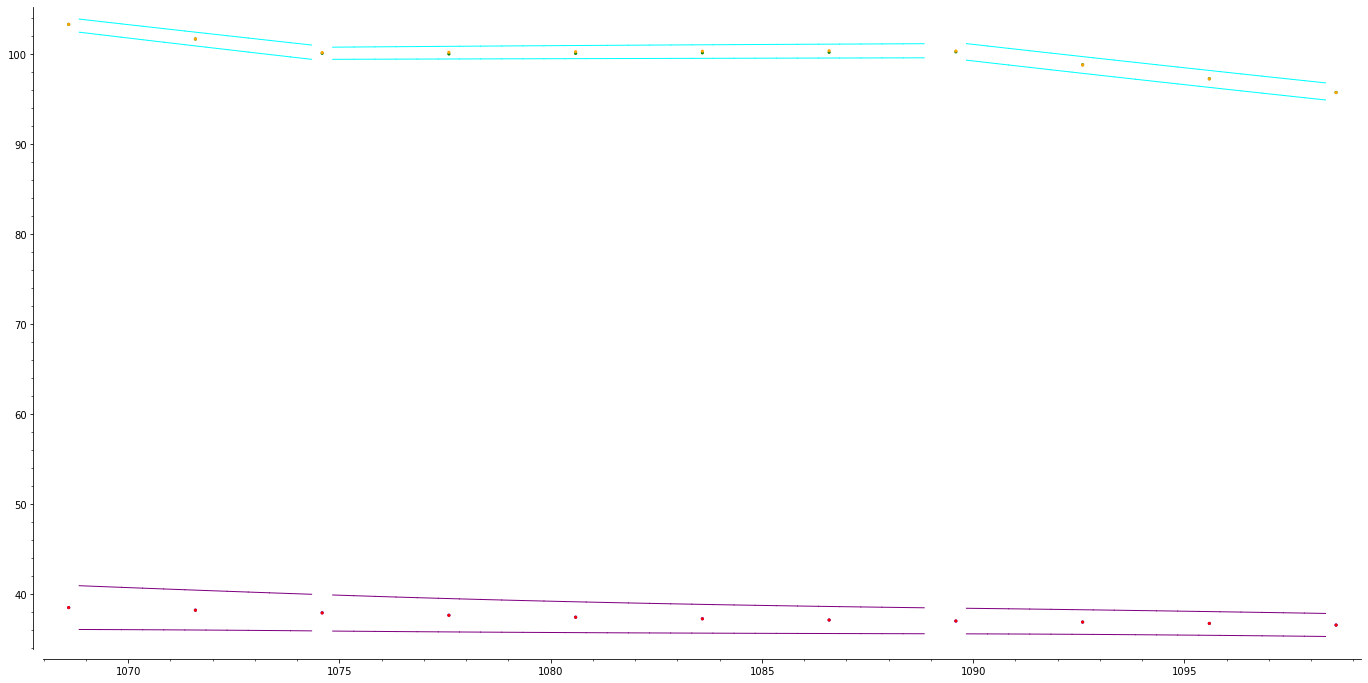

In [44]:
(  pT + pT_H
 + verified_trace3e.plot(('T_A', 'T_H'), color=('purple', 'cyan'))
).matplotlib()

In [45]:
violation_degree((times, reference_T, reference_T_heater), verified_trace3e)

0.000000000000000

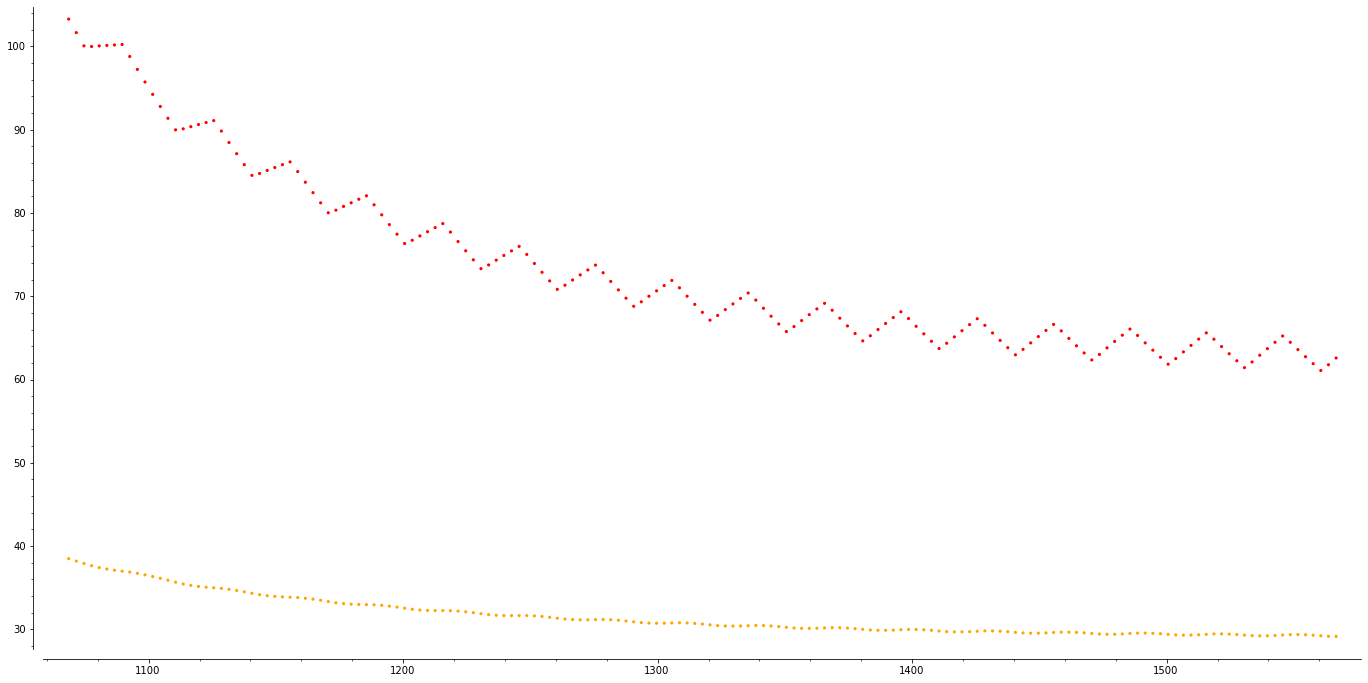

In [46]:
physical_data = sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][0],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='orange',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][0],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='red',
)
physical_data.matplotlib()

In [47]:
uncertainty_calibrator = UncertaintyCalibrator(database)

In [48]:
uncertainty_calibrator.calibrate(tstart, tend, C_air, G_box, C_heater, G_heater)

(103.?, 4.?e1, 93.?, 4.?e1, 137.?, 8.?)

In [49]:
uparams = _

In [50]:
params = ( m.self_adaptation_manager.state_machine.anomaly_parameters[1][0:2]
         + tuple(reversed(uparams[0:2]))
         + m.self_adaptation_manager.state_machine.anomaly_parameters[1][4:8]
         + uparams[2:4]
         + m.self_adaptation_manager.state_machine.anomaly_parameters[1][10:])
params

(1104.5938409201124,
 1604.5938409201124,
 4.?e1,
 103.?,
 21,
 3.0,
 10,
 5,
 93.?,
 4.?e1,
 227.76228512,
 1.92343277)

In [51]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(1104.5938409201124,
 1604.5938409201124,
 103.27713248422768?,
 38.485579315455411?,
 21,
 3.0,
 10,
 5,
 136.85583104560897,
 7.893908555093671,
 227.76228512,
 1.92343277)

In [52]:
verified_trace3b, verified_model3b = VerifiedPlantMonitor4Params.run_simulation(*params)

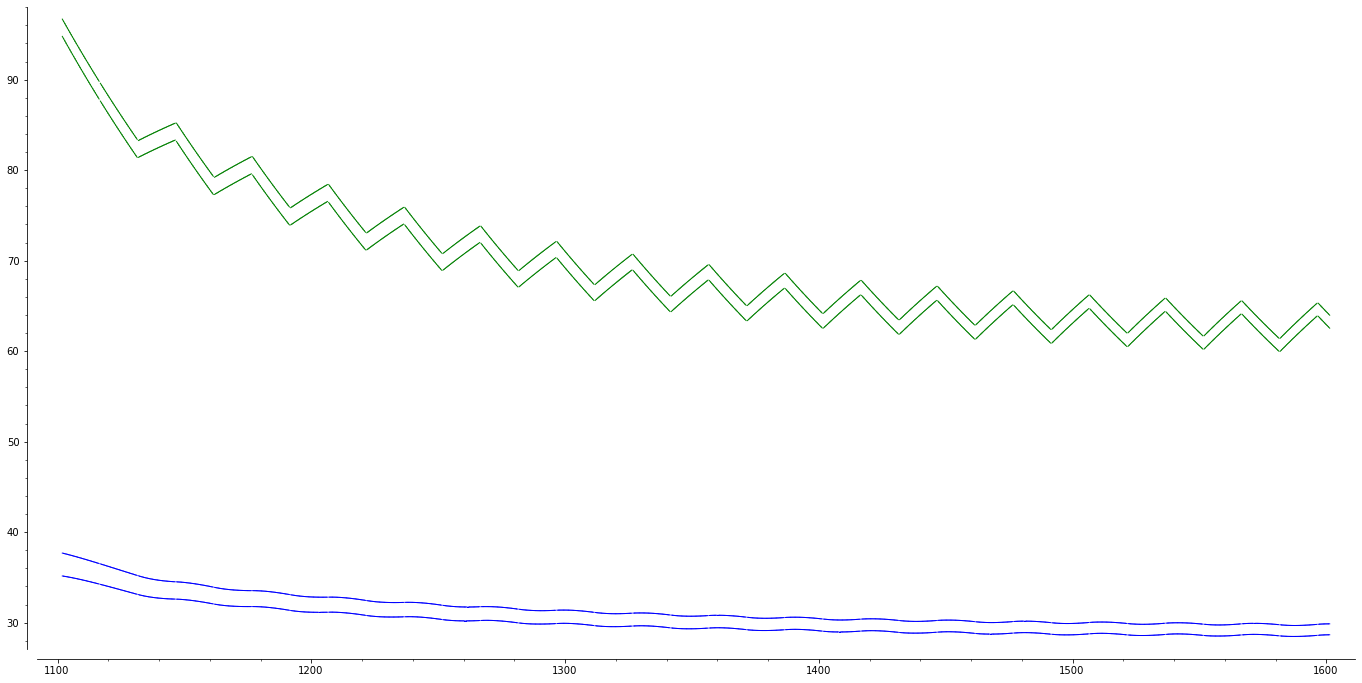

In [85]:
q = verified_trace3b.plot(('T_A', 'T_H'), color=('blue', 'green')); q.matplotlib()

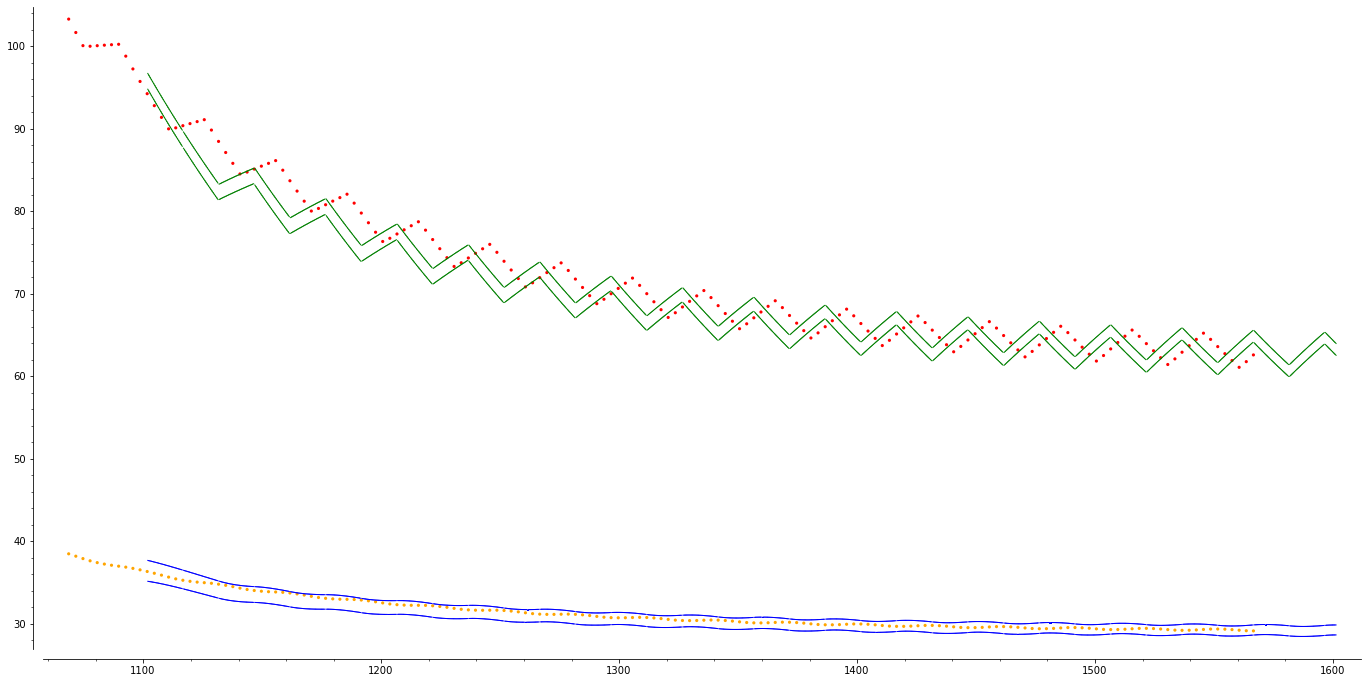

In [86]:
(physical_data + q).matplotlib()

In [ ]:
(times1, T1, T_heater1, heater_on1) in database.ctrl_optimal_policy_history[-1]